# Q1:

In [1]:
import pandas as pd
import os
from PIL import Image
import numpy as np

df_train = pd.read_csv('/kaggle/input/signature-verification-dataset/sign_data/train_data.csv')

base_dir = '/kaggle/input/signature-verification-dataset/sign_data/train/'

def load_signature_image(filename, img_size=(64, 64)):
    img_path = os.path.join(base_dir, filename)
    img = Image.open(img_path).convert("L")  # "L" for grayscale images
    img = img.resize(img_size)
    
    return np.array(img) / 255.  # Converting image to numpy array and normalizing [0,1]


images = [load_signature_image(row[0]) for index, row in df_train.iterrows()]


/tmp/ipykernel_31/2975794807.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  images = [load_signature_image(row[0]) for index, row in df_train.iterrows()]


In [2]:
len(images)

23205

## Augmentation:

In [3]:
import albumentations as A
import numpy as np
from tqdm import tqdm

# Augmentation pipeline 
augment = A.Compose([
    A.Rotate(limit=15, p=0.8),
    A.RandomScale(scale_limit=0.1, p=0.8),
    A.GaussNoise(var_limit=(10.0, 50.0), p=0.5),
    A.Resize(64, 64)  
])


# Number of augmented versions per image
num_aug_per_image = 3

augmented_images = []

for img in tqdm(images, desc="Augmenting dataset"):
    img = img.astype(np.uint8)  
    img_exp = np.expand_dims(img, axis=-1)  
    for _ in range(num_aug_per_image):
        augmented = augment(image=img_exp)['image']
        augmented = np.squeeze(augmented)
        augmented_images.append(augmented)

final_dataset = images + augmented_images
print(f"Original: {len(images)}, Augmented: {len(augmented_images)}, Total: {len(final_dataset)}")


/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.5' (you have '2.0.4'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
/tmp/ipykernel_31/3615071253.py:9: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(10.0, 50.0), p=0.5),
Augmenting dataset: 100%|██████████| 23205/23205 [00:29<00:00, 776.54it/s]

Original: 23205, Augmented: 69615, Total: 92820


In [4]:
len(final_dataset[1])

64

In [5]:
import torch
from torch.utils.data import Dataset

# Defining a custom PyTorch Dataset.
class SignatureAugDataset(Dataset):
    def __init__(self, images):
        self.images = images

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx].astype(np.float32) / 255.0  
        img = np.expand_dims(img, axis=0)  
        return torch.tensor(img, dtype=torch.float32)


In [6]:
aug_dataset = SignatureAugDataset(final_dataset)
aug_dataloader = torch.utils.data.DataLoader(aug_dataset, batch_size=32, shuffle=True)

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader


# Defining a custom PyTorch Dataset.
class SignatureDataset(Dataset):
    def __init__(self, images, transform=None):
    
        self.images = images
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        
        image = self.images[idx]
        image = np.expand_dims(image, axis=0)
        if self.transform:
            image = self.transform(image)
      
        image = torch.tensor(image, dtype=torch.float)
        return image


batch_size = 32
dataset = SignatureDataset(images)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [8]:
for batch in dataloader:
    print(batch.shape)  
    print(batch.dtype)  
    break


torch.Size([32, 1, 64, 64])
torch.float32


## VAE:

In [9]:
# Defining image and latent dimensions
img_channels = 1
img_size = 64
latent_dim = 32

class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        
        # Encoder (convolutional layers)
        self.encoder = nn.Sequential(
            nn.Conv2d(img_channels, 32, kernel_size=4, stride=2, padding=1),  # 64 -> 32
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),              # 32 -> 16
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),             # 16 -> 8
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),            # 8 -> 4
            nn.ReLU()
        )
        self.fc_mu   = nn.Linear(256 * 4 * 4, latent_dim)
        self.fc_logvar = nn.Linear(256 * 4 * 4, latent_dim)
        
        # Decoder
        self.fc_decoder = nn.Linear(latent_dim, 256 * 4 * 4)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),   # 4 -> 8
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),    # 8 -> 16
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),     # 16 -> 32
            nn.ReLU(),
            nn.ConvTranspose2d(32, img_channels, kernel_size=4, stride=2, padding=1),  # 32 -> 64
            nn.Sigmoid()  # Output in [0,1]
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)  # standard deviation
        eps = torch.randn_like(std)    # sample epsilon from standard normal
        return mu + eps * std

    def forward(self, x):
        batch_size = x.size(0)
        encoded = self.encoder(x)                   # shape: [B, 256, 4, 4]
        encoded = encoded.view(batch_size, -1)        # flatten
        mu = self.fc_mu(encoded)
        logvar = self.fc_logvar(encoded)
        z = self.reparameterize(mu, logvar)
        dec_input = self.fc_decoder(z)
        dec_input = dec_input.view(batch_size, 256, 4, 4)
        reconstructed = self.decoder(dec_input)
        return reconstructed, mu, logvar


def vae_loss(reconstructed, x, mu, logvar):
    
    # Reconstruction loss (binary cross-entropy)
    BCE = F.binary_cross_entropy(reconstructed, x, reduction='sum')
    
    # KL Divergence loss
    KL = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    
    return BCE + KL
    

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [11]:
print(torch.cuda.is_available()) 


True


In [12]:
# Instantiating the VAE model
vae_model = VAE().to(device)
optimizer_vae = optim.Adam(vae_model.parameters(), lr=1e-3)


In [14]:
# Training loop for VAE 
num_epochs_vae = 50
print("Training VAE...")
vae_model.train()

for epoch in range(num_epochs_vae):
    train_loss = 0
    for batch in dataloader:
        batch = batch.to(device)
        optimizer_vae.zero_grad()
        recon_batch, mu, logvar = vae_model(batch)
        loss = vae_loss(recon_batch, batch, mu, logvar)
        loss.backward()
        optimizer_vae.step()
        train_loss += loss.item()
        
    avg_loss = train_loss / len(dataset)
    print(f"[VAE Epoch {epoch+1}/{num_epochs_vae}] Loss: {avg_loss:.4f}")

Training VAE...
[VAE Epoch 1/50] Loss: 791.2345
[VAE Epoch 2/50] Loss: 779.5399
[VAE Epoch 3/50] Loss: 771.7128
[VAE Epoch 4/50] Loss: 766.5124
[VAE Epoch 5/50] Loss: 762.6512
[VAE Epoch 6/50] Loss: 759.7765
[VAE Epoch 7/50] Loss: 757.4124
[VAE Epoch 8/50] Loss: 755.4590
[VAE Epoch 9/50] Loss: 753.8877
[VAE Epoch 10/50] Loss: 752.5535
[VAE Epoch 11/50] Loss: 751.3747
[VAE Epoch 12/50] Loss: 750.1785
[VAE Epoch 13/50] Loss: 749.3370
[VAE Epoch 14/50] Loss: 748.3962
[VAE Epoch 15/50] Loss: 747.7049
[VAE Epoch 16/50] Loss: 747.0327
[VAE Epoch 17/50] Loss: 746.4747
[VAE Epoch 18/50] Loss: 745.9112
[VAE Epoch 19/50] Loss: 745.3948
[VAE Epoch 20/50] Loss: 744.7503
[VAE Epoch 21/50] Loss: 744.4501
[VAE Epoch 22/50] Loss: 744.0153
[VAE Epoch 23/50] Loss: 743.5841
[VAE Epoch 24/50] Loss: 743.2839
[VAE Epoch 25/50] Loss: 742.9032
[VAE Epoch 26/50] Loss: 742.4827
[VAE Epoch 27/50] Loss: 742.1299
[VAE Epoch 28/50] Loss: 741.8073
[VAE Epoch 29/50] Loss: 741.5145
[VAE Epoch 30/50] Loss: 741.3431
[VA

### Testing:

In [15]:
import pandas as pd
import os
from PIL import Image
import numpy as np

df_test = pd.read_csv('/kaggle/input/signature-verification-dataset/sign_data/test_data.csv')

base_dir = '/kaggle/input/signature-verification-dataset/sign_data/test/'

def load_signature_test_images(filename, img_size=(64, 64)):
    img_path = os.path.join(base_dir, filename)
    img = Image.open(img_path).convert("L")  # "L" for grayscale images
    img = img.resize(img_size)
            
    return np.array(img) / 255.  # Converting image to numpy array and normalizing [0,1]


test_images = [load_signature_test_images(row[0]) for index, row in df_test.iterrows()]


/tmp/ipykernel_31/3167606566.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  test_images = [load_signature_test_images(row[0]) for index, row in df_test.iterrows()]


In [16]:
len(test_images)

5747

In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader


# Defining a custom PyTorch Dataset
class SignatureDataset(Dataset):
    def __init__(self, images, transform=None):
        
        self.images = images
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        
        image = self.images[idx]
        image = np.expand_dims(image, axis=0)
        if self.transform:
            image = self.transform(image)
        
        image = torch.tensor(image, dtype=torch.float)
        return image


batch_size = 1
test_dataset = SignatureDataset(test_images)
test_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [18]:
import torch.nn.functional as F

vae_model.eval()
total_loss = 0

with torch.no_grad():
    for img in test_dataloader:
        img = img.to(device)
        recon, mu, logvar = vae_model(img)
        loss = F.mse_loss(recon, img)  
        total_loss += loss.item()


In [19]:
avg_test_loss = total_loss / len(test_dataloader)
print(f"Average reconstruction loss on test set: {avg_test_loss:.4f}")

Average reconstruction loss on test set: 0.0019


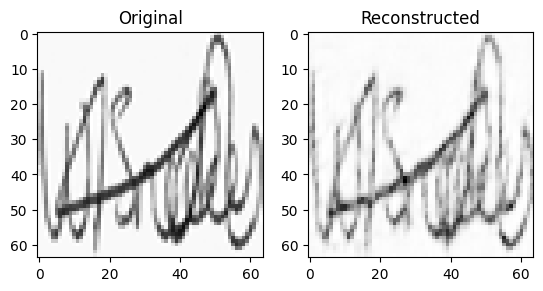

In [20]:
import matplotlib.pyplot as plt

vae_model.eval()
with torch.no_grad():
    test_img = test_dataset[0].unsqueeze(0).to(device)
    recon, _, _ = vae_model(test_img)

    fig, axes = plt.subplots(1, 2)
    axes[0].imshow(test_img.cpu().squeeze(), cmap='gray')
    axes[0].set_title("Original")

    axes[1].imshow(recon.cpu().squeeze(), cmap='gray')
    axes[1].set_title("Reconstructed")
    plt.show()


## GAN:

In [21]:
class Generator(nn.Module):
    def __init__(self, latent_dim, img_channels=1, img_size=64):
        super(Generator, self).__init__()
        self.init_size = img_size // 4   # initial image size after FC layer
        self.fc = nn.Sequential(
            nn.Linear(latent_dim, 128 * self.init_size * self.init_size),
            nn.ReLU(True)
        )
        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),  # upscale: init_size -> init_size*2
            nn.ReLU(True),
            nn.ConvTranspose2d(64, img_channels, kernel_size=4, stride=2, padding=1),  # upscale to original size
            nn.Tanh()  # using Tanh implies data should be in [-1,1]
        )

    def forward(self, z):
        out = self.fc(z)
        out = out.view(z.size(0), 128, self.init_size, self.init_size)
        img = self.deconv(out)
        return img


class Discriminator(nn.Module):
    def __init__(self, img_channels=1, img_size=64):
        super(Discriminator, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(img_channels, 64, kernel_size=4, stride=2, padding=1),  # 64 -> 32
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),             # 32 -> 16
            nn.LeakyReLU(0.2, inplace=True)
        )
        ds_size = img_size // 4   # after two Conv2d with stride 2
        self.fc = nn.Sequential(
            nn.Linear(128 * ds_size * ds_size, 1),
            nn.Sigmoid()
        )

    def forward(self, img):
        out = self.conv(img)
        out = out.view(img.size(0), -1)
        validity = self.fc(out)
        return validity


In [22]:
# Instantiating GAN models
latent_dim = 100
generator = Generator(latent_dim=latent_dim).to(device)
discriminator = Discriminator().to(device)

# Optimizers for GAN
optimizer_G = optim.Adam(generator.parameters(), lr=1e-4)
optimizer_D = optim.Adam(discriminator.parameters(), lr=1e-4)
adversarial_loss = nn.BCELoss()


In [23]:
# For GAN training, we will re-scale the images to [-1, 1] because the generator uses Tanh.
def rescale_for_gan(x):
    return x * 2 - 1

# Training loop for GAN 
num_epochs_gan = 50
print("\nTraining GAN...")
generator.train()
discriminator.train()

for epoch in range(num_epochs_gan):
    d_loss_epoch = 0
    g_loss_epoch = 0
    for batch in dataloader:
        batch = batch.to(device)
        
        # Rescaling images for GAN training
        real_imgs = rescale_for_gan(batch)
        batch_size = real_imgs.size(0)
        
        # Ground truths
        valid = torch.ones(batch_size, 1, device=device)
        fake = torch.zeros(batch_size, 1, device=device)

        
        # Training Discriminator
       
        optimizer_D.zero_grad()
        # Loss on real images
        real_loss = adversarial_loss(discriminator(real_imgs), valid)
        
        # Generating fake images
        z = torch.randn(batch_size, latent_dim, device=device)
        gen_imgs = generator(z)
        fake_loss = adversarial_loss(discriminator(gen_imgs.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2
        d_loss.backward()
        optimizer_D.step()
  
       
        # Training Generator
        optimizer_G.zero_grad()
        
        # Generator tries to fool the discriminator
        g_loss = adversarial_loss(discriminator(gen_imgs), valid)
        g_loss.backward()
        optimizer_G.step()
        
        d_loss_epoch += d_loss.item()
        g_loss_epoch += g_loss.item()
        
    avg_d_loss = d_loss_epoch / len(dataset) * batch_size
    avg_g_loss = g_loss_epoch / len(dataset) * batch_size
    print(f"[GAN Epoch {epoch+1}/{num_epochs_gan}] D Loss: {avg_d_loss:.4f} | G Loss: {avg_g_loss:.4f}")


Training GAN...
[GAN Epoch 1/50] D Loss: 0.0421 | G Loss: 0.7058
[GAN Epoch 2/50] D Loss: 0.0379 | G Loss: 0.5305
[GAN Epoch 3/50] D Loss: 0.0366 | G Loss: 0.6867
[GAN Epoch 4/50] D Loss: 0.0056 | G Loss: 0.5799
[GAN Epoch 5/50] D Loss: 0.0017 | G Loss: 0.7484
[GAN Epoch 6/50] D Loss: 0.0228 | G Loss: 1.3292
[GAN Epoch 7/50] D Loss: 0.0000 | G Loss: 1.5397
[GAN Epoch 8/50] D Loss: 0.0000 | G Loss: 1.7722
[GAN Epoch 9/50] D Loss: 0.0034 | G Loss: 6.7897
[GAN Epoch 10/50] D Loss: 0.0000 | G Loss: 9.0984
[GAN Epoch 11/50] D Loss: 0.0000 | G Loss: 9.0977
[GAN Epoch 12/50] D Loss: 0.0000 | G Loss: 9.0988
[GAN Epoch 13/50] D Loss: 0.0000 | G Loss: 9.0986
[GAN Epoch 14/50] D Loss: 0.0000 | G Loss: 9.0981
[GAN Epoch 15/50] D Loss: 0.0000 | G Loss: 9.0984
[GAN Epoch 16/50] D Loss: 0.0000 | G Loss: 9.0974
[GAN Epoch 17/50] D Loss: 0.0000 | G Loss: 9.0967
[GAN Epoch 18/50] D Loss: 0.0000 | G Loss: 9.0982
[GAN Epoch 19/50] D Loss: 0.0000 | G Loss: 9.0986
[GAN Epoch 20/50] D Loss: 0.0000 | G Loss:

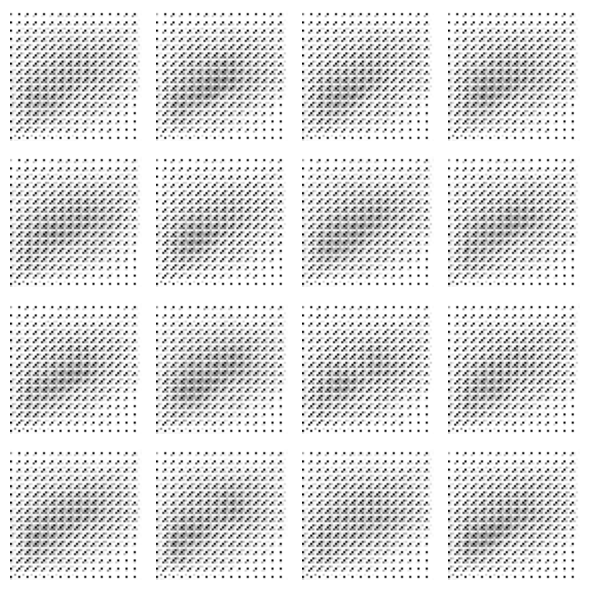

In [24]:
# After training, generating some images to visualize
import matplotlib.pyplot as plt

generator.eval()
with torch.no_grad():
    z = torch.randn(16, latent_dim, device=device)
    gen_imgs = generator(z).detach().cpu()
    
    gen_imgs = (gen_imgs + 1) / 2

    # Plotting 16 generated images in a 4x4 grid
    fig, axes = plt.subplots(4, 4, figsize=(6, 6))
    for i, ax in enumerate(axes.flatten()):
        ax.imshow(gen_imgs[i].squeeze(), cmap='gray')
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# Q2:

In [25]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset
import torchvision
import torchvision.transforms as transforms
import numpy as np


transform = transforms.Compose([
    transforms.ToTensor(),          # converts to tensor in [0,1] of shape [C, H, W]
])

# Loading training data
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

# Getting indices of cats and dogs labels:
selected_idx = [i for i, (_, label) in enumerate(trainset) if label in (3, 5)]
train_subset = Subset(trainset, selected_idx)
train_loader = DataLoader(train_subset, batch_size=64, shuffle=True, num_workers=2)

100%|██████████| 170M/170M [00:02<00:00, 79.5MB/s] 


Extracting ./data/cifar-10-python.tar.gz to ./data


In [26]:
trainset

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
           )

In [27]:
# MODEL DEFINITIONS

latent_dim = 100  # Dimension of noise for generator

## Generator: A DCGAN-style generator that maps a noise vector to a 3x32x32 image.
class Generator(nn.Module):
    def __init__(self, latent_dim, channels=3, feature_map_size=64):
        super(Generator, self).__init__()
        self.net = nn.Sequential(
            
            # Input: latent_dim x 1 x 1
            nn.ConvTranspose2d(latent_dim, feature_map_size * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(feature_map_size * 8),
            nn.ReLU(True),
            
            # State: (feature_map_size*8) x 4 x 4
            nn.ConvTranspose2d(feature_map_size * 8, feature_map_size * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_map_size * 4),
            nn.ReLU(True),
            
            # State: (feature_map_size*4) x 8 x 8
            nn.ConvTranspose2d(feature_map_size * 4, feature_map_size * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_map_size * 2),
            nn.ReLU(True),
            
            # State: (feature_map_size*2) x 16 x 16
            nn.ConvTranspose2d(feature_map_size * 2, feature_map_size, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_map_size),
            nn.ReLU(True),
            
            # State: (feature_map_size) x 32 x 32
            nn.ConvTranspose2d(feature_map_size, channels, 3, 1, 1, bias=False),
            nn.Tanh()  # Outputs in [-1, 1]
        )
        
    def forward(self, z):
        # Reshaping noise from [batch, latent_dim] to [batch, latent_dim, 1, 1]
        z = z.view(z.size(0), latent_dim, 1, 1)
        img = self.net(z)
        return img


## Discriminator: A Siamese network structure.
# It uses a shared convolutional encoder to map an image to a feature vector.
# For two inputs, it computes the absolute difference of the features and then outputs a similarity score.
class SiameseEncoder(nn.Module):
    def __init__(self, channels=3, feature_dim=128):
        super(SiameseEncoder, self).__init__()
        self.features = nn.Sequential(
            
            # Input: [channels, 32, 32]
            nn.Conv2d(channels, 64, kernel_size=4, stride=2, padding=1),  # 32->16
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),         # 16->8
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, feature_dim, kernel_size=4, stride=2, padding=1),  # 8->4
            nn.BatchNorm2d(feature_dim),
            nn.LeakyReLU(0.2, inplace=True),
        )
        
    def forward(self, img):
        out = self.features(img)  # shape: [B, feature_dim, 4, 4]
        out = out.view(out.size(0), -1)  # flatten to [B, feature_dim*16]
        return out


class Discriminator(nn.Module):
    def __init__(self, channels=3, feature_dim=128):
        super(Discriminator, self).__init__()
        
        self.encoder = SiameseEncoder(channels, feature_dim)
        # Fully connected layer to output similarity score.
        # I would use the absolute difference between features.
        self.fc = nn.Sequential(
            nn.Linear(feature_dim * 16, 64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(64, 1),
            nn.Sigmoid()  # Similarity score in [0,1]
        )
        
    def forward(self, img1, img2):
        feat1 = self.encoder(img1)
        feat2 = self.encoder(img2)
        
        # Computing absolute difference between feature vectors
        diff = torch.abs(feat1 - feat2)
        similarity = self.fc(diff)
        return similarity

In [28]:
# INITIALIZING MODELS AND OPTIMIZERS

generator = Generator(latent_dim=latent_dim).to(device)
discriminator = Discriminator().to(device)

optimizer_G = optim.Adam(generator.parameters(), lr=2e-4, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=2e-4, betas=(0.5, 0.999))
criterion = nn.BCELoss()  # Binary Cross-Entropy


In [29]:
# TRAINING LOOP

num_epochs = 50  
print("Starting Training...")

for epoch in range(num_epochs):
    for real_imgs, _ in train_loader:
        batch_size = real_imgs.size(0)
        
        # We use images in range [0,1] from CIFAR-10; rescale them to [-1,1]
        real_imgs = real_imgs.to(device) * 2 - 1  

        # Training Discriminator
       
        optimizer_D.zero_grad()
        
        # Creating positive pairs: real-real (using the same image twice)
        sim_pos = discriminator(real_imgs, real_imgs)
        target_pos = torch.ones(batch_size, 1, device=device)  # similarity = 1 for positive pair
        
        loss_pos = criterion(sim_pos, target_pos)
        
        # Creating negative pairs: (fake, real)
        z = torch.randn(batch_size, latent_dim, device=device)
        fake_imgs = generator(z)
        
        # We want the similarity score to be 0 for (fake, real)
        sim_neg = discriminator(fake_imgs, real_imgs)
        target_neg = torch.zeros(batch_size, 1, device=device)
        
        loss_neg = criterion(sim_neg, target_neg)
        
        d_loss = (loss_pos + loss_neg) / 2
        d_loss.backward()
        optimizer_D.step()

        
        # Training Generator
       
        optimizer_G.zero_grad()
        
        # Generating fake images again
        z = torch.randn(batch_size, latent_dim, device=device)
        fake_imgs = generator(z)
        
        # For generator update, pairing fake image with a real image and target similarity is 1
        sim_gen = discriminator(fake_imgs, real_imgs)
        
        # Generator tries to produce images that, when paired with a real image, yield high similarity.
        g_loss = criterion(sim_gen, target_pos)  # target = 1, because we want them to be similar
        g_loss.backward()
        optimizer_G.step()
    
    print(f"Epoch [{epoch+1}/{num_epochs}]  D_loss: {d_loss.item():.4f}  G_loss: {g_loss.item():.4f}")

Starting Training...
Epoch [1/50]  D_loss: 0.2957  G_loss: 8.3840
Epoch [2/50]  D_loss: 0.2467  G_loss: 9.9883
Epoch [3/50]  D_loss: 0.1884  G_loss: 11.7438
Epoch [4/50]  D_loss: 0.1351  G_loss: 13.6785
Epoch [5/50]  D_loss: 0.0942  G_loss: 15.5991
Epoch [6/50]  D_loss: 0.0658  G_loss: 16.8200
Epoch [7/50]  D_loss: 0.0467  G_loss: 18.5077
Epoch [8/50]  D_loss: 0.0340  G_loss: 19.9200
Epoch [9/50]  D_loss: 0.0254  G_loss: 20.5589
Epoch [10/50]  D_loss: 0.0194  G_loss: 21.7746
Epoch [11/50]  D_loss: 0.0152  G_loss: 22.0787
Epoch [12/50]  D_loss: 0.0121  G_loss: 22.7151
Epoch [13/50]  D_loss: 0.0097  G_loss: 23.7438
Epoch [14/50]  D_loss: 0.0080  G_loss: 24.4522
Epoch [15/50]  D_loss: 0.0066  G_loss: 25.0245
Epoch [16/50]  D_loss: 0.0055  G_loss: 25.4272
Epoch [17/50]  D_loss: 0.0047  G_loss: 26.2610
Epoch [18/50]  D_loss: 0.0040  G_loss: 26.0765
Epoch [19/50]  D_loss: 0.0034  G_loss: 27.3157
Epoch [20/50]  D_loss: 0.0029  G_loss: 27.7349
Epoch [21/50]  D_loss: 0.0025  G_loss: 28.1546
Epo

# Q3:

In [30]:
import os
import glob
import numpy as np
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
img_size = 64     # using 64x64 images for both sketches and photos
latent_dim = 100  # dimension of noise vector
batch_size = 64


# Normalizing images to [-1, 1] since I would use Tanh in generator
transform_img = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])


# DATASET
class FaceSketchDataset(Dataset):
    def __init__(self, root_dir, phase='train', transform=None):
    
        self.photos_dir = os.path.join(root_dir, phase, 'photos')
        self.sketches_dir = os.path.join(root_dir, phase, 'sketches')
        self.transform = transform
        
        # Getting sorted list (assuming identical naming conventions)
        self.photo_paths = sorted(glob.glob(os.path.join(self.photos_dir, '*.*')))
        self.sketch_paths = sorted(glob.glob(os.path.join(self.sketches_dir, '*.*')))
        assert len(self.photo_paths) == len(self.sketch_paths), "Mismatch between photos and sketches count"

    def __len__(self):
        return len(self.photo_paths)

    def __getitem__(self, idx):
        photo = Image.open(self.photo_paths[idx]).convert("RGB")
        sketch = Image.open(self.sketch_paths[idx]).convert("L")  
        if self.transform:
            photo = self.transform(photo)     # [3, img_size, img_size]
            sketch = self.transform(sketch)   
            
        # For sketch, convert to 1-channel manually:
        sketch = transforms.Grayscale(num_output_channels=1)(sketch)
        return sketch, photo  # condition (sketch) and target (photo)


# Creating dataset 
dataset_root = '/kaggle/input/person-face-sketches'
train_dataset = FaceSketchDataset(dataset_root, phase='train', transform=transform_img)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)



In [31]:
len(train_dataset)

20655

In [32]:
# MODEL DEFINITIONS

# Generator: Conditions on sketch + noise.
class Generator(nn.Module):
    def __init__(self, latent_dim, sketch_channels=1, img_channels=3, feature_map_size=64):
        super(Generator, self).__init__()
        self.latent_dim = latent_dim
        self.sketch_channels = sketch_channels
        
        # Encoder branch for the sketch (condition) to extract a feature vector.
        self.sketch_encoder = nn.Sequential(
            nn.Conv2d(sketch_channels, 32, kernel_size=4, stride=2, padding=1),  # 64 -> 32
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),              # 32 -> 16
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),             # 16 -> 8
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),            # 8 -> 4
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
        )
        self.sketch_fc = nn.Linear(256 * 4 * 4, 100)  # project sketch to a 100-dim vector

        # Combining noise and sketch condition
        self.fc = nn.Linear(latent_dim + 100, feature_map_size * 8 * 4 * 4)

        self.gen = nn.Sequential(
            
            # State: [feature_map_size*8, 4, 4]
            nn.ConvTranspose2d(feature_map_size * 8, feature_map_size * 4, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(feature_map_size * 4),
            nn.ReLU(True),
            
            # State: [feature_map_size*4, 8, 8]
            nn.ConvTranspose2d(feature_map_size * 4, feature_map_size * 2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(feature_map_size * 2),
            nn.ReLU(True),
            
            # State: [feature_map_size*2, 16, 16]
            nn.ConvTranspose2d(feature_map_size * 2, feature_map_size, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(feature_map_size),
            nn.ReLU(True),
            
            # State: [feature_map_size, 32, 32]
            nn.ConvTranspose2d(feature_map_size, img_channels, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh()  # outputs image in [-1,1]
        )

    def forward(self, sketch, z):
        
        # sketch: [B, 1, 64, 64]; z: [B, latent_dim]
        B = sketch.size(0)
        
        # Extracting sketch condition features
        s = self.sketch_encoder(sketch)  # [B, 256, 4, 4]
        s = s.view(B, -1)
        s = self.sketch_fc(s)  # [B, 100]
        
        # Concatenating noise vector and sketch condition vector
        combined = torch.cat([z, s], dim=1)  # [B, latent_dim + 100]
        fc_out = self.fc(combined)          # [B, feature_map_size*8*4*4]
        fc_out = fc_out.view(B, -1, 4, 4)
        img = self.gen(fc_out)
        return img


# Discriminator: It takes a pair (sketch, image) as input.
class Discriminator(nn.Module):
    def __init__(self, sketch_channels=1, img_channels=3, feature_map_size=64):
        super(Discriminator, self).__init__()
        
        # Combining the sketch and image by concatenating along channel dimension:
        self.net = nn.Sequential(
            
            # Input: [sketch_channels+img_channels, 64, 64]
            nn.Conv2d(sketch_channels + img_channels, feature_map_size, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            
            # state: [feature_map_size, 32, 32]
            nn.Conv2d(feature_map_size, feature_map_size*2, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(feature_map_size*2),
            nn.LeakyReLU(0.2, inplace=True),
            
            # state: [feature_map_size*2, 16, 16]
            nn.Conv2d(feature_map_size*2, feature_map_size*4, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(feature_map_size*4),
            nn.LeakyReLU(0.2, inplace=True),
            
            # state: [feature_map_size*4, 8, 8]
            nn.Conv2d(feature_map_size*4, feature_map_size*8, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(feature_map_size*8),
            nn.LeakyReLU(0.2, inplace=True),
            # state: [feature_map_size*8, 4, 4]
        )
        self.fc = nn.Sequential(
            nn.Linear(feature_map_size*8*4*4, 1),
            nn.Sigmoid()  # similarity score between 0 and 1
        )
    def forward(self, sketch, image):
        
        # Concatenating along channel dimension
        x = torch.cat([sketch, image], dim=1)  # shape: [B, 1+3, 64,64]
        features = self.net(x)
        features = features.view(features.size(0), -1)
        out = self.fc(features)
        return out


In [33]:
# INITIALIZING MODELS & OPTIMIZERS
generator = Generator(latent_dim=latent_dim).to(device)
discriminator = Discriminator().to(device)

optimizer_G = optim.Adam(generator.parameters(), lr=2e-4, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=2e-4, betas=(0.5, 0.999))
criterion = nn.BCELoss()   # Binary Cross-Entropy Loss



In [35]:
# Training

num_epochs = 20

print("Starting cGAN Training...")
for epoch in range(num_epochs):
    for sketches, photos in train_loader:
        batch_size = sketches.size(0)
        
        sketches = sketches.to(device)  
        photos = photos.to(device)        
        photos = photos * 2 - 1

       
        # Training Discriminator
        
        optimizer_D.zero_grad()

        # Real pair: (sketch, real photo), label = 1
        real_labels = torch.ones(batch_size, 1, device=device)
        real_out = discriminator(sketches, photos)
        d_loss_real = criterion(real_out, real_labels)

        # Fake pair: (sketch, fake photo generated by G), label = 0
        z = torch.randn(batch_size, latent_dim, device=device)
        fake_photos = generator(sketches, z)
        fake_labels = torch.zeros(batch_size, 1, device=device)
        fake_out = discriminator(sketches, fake_photos.detach())
        d_loss_fake = criterion(fake_out, fake_labels)

        d_loss = (d_loss_real + d_loss_fake) / 2
        d_loss.backward()
        optimizer_D.step()

        
        # Training Generator
       
        optimizer_G.zero_grad()
       
        fake_out = discriminator(sketches, fake_photos)
        g_loss = criterion(fake_out, real_labels)  # target=1
        g_loss.backward()
        optimizer_G.step()

    print(f"Epoch [{epoch+1}/{num_epochs}]  D_loss: {d_loss.item():.4f}  G_loss: {g_loss.item():.4f}")



Starting cGAN Training...
Epoch [1/20]  D_loss: 0.0000  G_loss: 11.8693
Epoch [2/20]  D_loss: 0.0000  G_loss: 12.0401
Epoch [3/20]  D_loss: 0.0000  G_loss: 12.6506
Epoch [4/20]  D_loss: 0.0000  G_loss: 13.0997
Epoch [5/20]  D_loss: 0.0000  G_loss: 13.7158
Epoch [6/20]  D_loss: 0.0000  G_loss: 13.5614
Epoch [7/20]  D_loss: 0.0000  G_loss: 13.7995
Epoch [8/20]  D_loss: 0.0000  G_loss: 13.8937
Epoch [9/20]  D_loss: 0.0000  G_loss: 13.6788
Epoch [10/20]  D_loss: 0.0000  G_loss: 14.2883
Epoch [11/20]  D_loss: 0.0000  G_loss: 13.9563
Epoch [12/20]  D_loss: 0.0000  G_loss: 14.5722
Epoch [13/20]  D_loss: 0.0000  G_loss: 14.7347
Epoch [14/20]  D_loss: 0.0000  G_loss: 14.2221
Epoch [15/20]  D_loss: 0.0000  G_loss: 14.0519
Epoch [16/20]  D_loss: 0.0000  G_loss: 14.6712
Epoch [17/20]  D_loss: 0.0000  G_loss: 14.8740
Epoch [18/20]  D_loss: 0.0000  G_loss: 15.0500
Epoch [19/20]  D_loss: 0.0000  G_loss: 15.4462
Epoch [20/20]  D_loss: 0.0000  G_loss: 15.5418


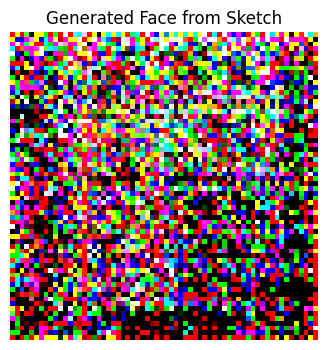

In [36]:
# VISUALIZATION: 

generator.eval()
with torch.no_grad():
    
    sample_sketch, _ = train_dataset[5000] 
    sample_sketch = sample_sketch.unsqueeze(0).to(device)
    z = torch.randn(1, latent_dim, device=device)
    generated_face = generator(sample_sketch, z)
  
    generated_face = (generated_face + 1) / 2.0
    
    gen_face_np = generated_face.squeeze().permute(1,2,0).cpu().numpy()
    
    plt.figure(figsize=(4,4))
    plt.imshow(gen_face_np)
    plt.title("Generated Face from Sketch")
    plt.axis("off")
    plt.show()

# Q4:

In [45]:
import os, glob, itertools
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
img_size = 64
batch_size = 1  
num_epochs = 100 

# Resizing to 64x64, converting to tensor, and normalizing to [-1,1]
transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)  
])


# Dataset Loading
class CycleGANDataset(Dataset):
    def __init__(self, root_dir, phase='train', transform=None):
       
        self.transform = transform
        self.domainA_dir = os.path.join(root_dir, phase, 'photos')
        self.domainB_dir = os.path.join(root_dir, phase, 'sketches')
        self.domainA_paths = sorted(glob.glob(os.path.join(self.domainA_dir, '*.*')))
        self.domainB_paths = sorted(glob.glob(os.path.join(self.domainB_dir, '*.*')))
        
    def __len__(self):
        return max(len(self.domainA_paths), len(self.domainB_paths))
        
    def __getitem__(self, idx):
        path_A = self.domainA_paths[idx % len(self.domainA_paths)]
        path_B = self.domainB_paths[idx % len(self.domainB_paths)]
        image_A = Image.open(path_A).convert("RGB")
        image_B = Image.open(path_B).convert("RGB")
        
        if self.transform:
            image_A = self.transform(image_A)
            image_B = self.transform(image_B)
        return {'A': image_A, 'B': image_B}


dataset_root = "/kaggle/input/person-face-sketches"
train_dataset = CycleGANDataset(dataset_root, phase='train', transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

In [46]:
# MODEL DEFINITIONS

# Residual Blocks
class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.block = nn.Sequential(
            nn.Conv2d(channels, channels, kernel_size=3, padding=1, bias=False),
            nn.InstanceNorm2d(channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(channels, channels, kernel_size=3, padding=1, bias=False),
            nn.InstanceNorm2d(channels)
        )
        
    def forward(self, x):
        return x + self.block(x)


# Using ResNet-based Generator (similar to CycleGAN original)
class ResNetGenerator(nn.Module):
    def __init__(self, input_channels=3, output_channels=3, n_residual_blocks=6):
        super(ResNetGenerator, self).__init__()
        
        # Initial convolution block
        model = [
            nn.Conv2d(input_channels, 64, kernel_size=7, padding=3, bias=False),
            nn.InstanceNorm2d(64),
            nn.ReLU(inplace=True)
        ]
        
        # Downsampling
        in_channels = 64
        out_channels = in_channels * 2
        for _ in range(2):
            model += [
                nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1, bias=False),
                nn.InstanceNorm2d(out_channels),
                nn.ReLU(inplace=True)
            ]
            in_channels = out_channels
            out_channels = in_channels * 2
            
        # Residual blocks
        for _ in range(n_residual_blocks):
            model += [ResidualBlock(in_channels)]
            
        # Upsampling
        out_channels = in_channels // 2
        for _ in range(2):
            model += [
                nn.ConvTranspose2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1, output_padding=1, bias=False),
                nn.InstanceNorm2d(out_channels),
                nn.ReLU(inplace=True)
            ]
            in_channels = out_channels
            out_channels = in_channels // 2
            
        # Final layer
        model += [
            nn.Conv2d(64, output_channels, kernel_size=7, padding=3),
            nn.Tanh()
        ]
        self.model = nn.Sequential(*model)
        
    def forward(self, x):
        return self.model(x)


# Using PatchGAN Discriminator 
class Discriminator(nn.Module):
    def __init__(self, input_channels=3):
        super(Discriminator, self).__init__()
        model = [
            nn.Conv2d(input_channels, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True)
        ]
        in_channels = 64
        out_channels = in_channels * 2
        for _ in range(3):
            model += [
                nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1, bias=False),
                nn.InstanceNorm2d(out_channels),
                nn.LeakyReLU(0.2, inplace=True)
            ]
            in_channels = out_channels
            out_channels = in_channels * 2
            
        # Outputs 1-channel prediction map
        model += [nn.Conv2d(in_channels, 1, kernel_size=4, padding=1)]
        self.model = nn.Sequential(*model)
        
    def forward(self, x):
        return self.model(x)

In [48]:
# Instantiating 
# Two generators and two discriminators

netG_A2B = ResNetGenerator(input_channels=3, output_channels=3, n_residual_blocks=6).to(device)
netG_B2A = ResNetGenerator(input_channels=3, output_channels=3, n_residual_blocks=6).to(device)
netD_A = Discriminator(input_channels=3).to(device)
netD_B = Discriminator(input_channels=3).to(device)


# Using Mean Squared Error for GAN loss
criterion_GAN = nn.MSELoss()

# Cycle consistency loss: L1 loss
criterion_cycle = nn.L1Loss()

# Identity loss 
criterion_identity = nn.L1Loss()

optimizer_G = optim.Adam(itertools.chain(netG_A2B.parameters(), netG_B2A.parameters()), lr=0.0002, betas=(0.5, 0.999))
optimizer_D_A = optim.Adam(netD_A.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D_B = optim.Adam(netD_B.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [49]:
# Training

def get_target_tensor(input_tensor, target_is_real):
    if target_is_real:
        return torch.ones_like(input_tensor, device=device)
    else:
        return torch.zeros_like(input_tensor, device=device)


print("CycleGAN training started")
for epoch in range(num_epochs):
    for i, data in enumerate(train_loader):
        real_A = data['A'].to(device)  # photos
        real_B = data['B'].to(device)  # sketches

        
        # Training Generators
       
        optimizer_G.zero_grad()
        
        # Identity loss
        idt_A = netG_B2A(real_A)
        loss_id_A = criterion_identity(idt_A, real_A)
        idt_B = netG_A2B(real_B)
        loss_id_B = criterion_identity(idt_B, real_B)
        loss_identity = (loss_id_A + loss_id_B) * 0.5

        
        # GAN loss
        fake_B = netG_A2B(real_A)
        pred_fake_B = netD_B(fake_B)
        target_real_B = get_target_tensor(pred_fake_B, True)
        loss_GAN_A2B = criterion_GAN(pred_fake_B, target_real_B)
        
        fake_A = netG_B2A(real_B)
        pred_fake_A = netD_A(fake_A)
        target_real_A = get_target_tensor(pred_fake_A, True)
        loss_GAN_B2A = criterion_GAN(pred_fake_A, target_real_A)
        loss_GAN = (loss_GAN_A2B + loss_GAN_B2A) * 0.5

        
        # Cycle consistency loss
        recov_A = netG_B2A(fake_B)
        loss_cycle_A = criterion_cycle(recov_A, real_A)
        recov_B = netG_A2B(fake_A)
        loss_cycle_B = criterion_cycle(recov_B, real_B)
        loss_cycle = (loss_cycle_A + loss_cycle_B) * 0.5

        loss_G = loss_GAN + 10.0 * loss_cycle + 5.0 * loss_identity
        loss_G.backward()
        optimizer_G.step()

        
        # Training A Discriminator
       
        optimizer_D_A.zero_grad()
        
        # Real loss
        pred_real_A = netD_A(real_A)
        target_real_A = get_target_tensor(pred_real_A, True)
        loss_D_A_real = criterion_GAN(pred_real_A, target_real_A)
        
        # Fake loss
        pred_fake_A = netD_A(fake_A.detach())
        target_fake_A = get_target_tensor(pred_fake_A, False)
        loss_D_A_fake = criterion_GAN(pred_fake_A, target_fake_A)
        loss_D_A = (loss_D_A_real + loss_D_A_fake) * 0.5
        loss_D_A.backward()
        optimizer_D_A.step()

       
        # Training B Discriminator
        
        optimizer_D_B.zero_grad()
        pred_real_B = netD_B(real_B)
        target_real_B = get_target_tensor(pred_real_B, True)
        loss_D_B_real = criterion_GAN(pred_real_B, target_real_B)
        pred_fake_B = netD_B(fake_B.detach())
        target_fake_B = get_target_tensor(pred_fake_B, False)
        loss_D_B_fake = criterion_GAN(pred_fake_B, target_fake_B)
        loss_D_B = (loss_D_B_real + loss_D_B_fake) * 0.5
        loss_D_B.backward()
        optimizer_D_B.step()

    print(f"Epoch [{epoch+1}/{num_epochs}]  Loss_G: {loss_G.item():.4f}  Loss_D_A: {loss_D_A.item():.4f}  Loss_D_B: {loss_D_B.item():.4f}")

    if epoch == 25 or epoch == 50 or epoch == 75 or epoch == 98 or epoch == 99:
    
        torch.save(netG_A2B.state_dict(), f"netG_A2B_epoch{epoch+1}.pth")
        torch.save(netG_B2A.state_dict(), f"netG_B2A_epoch{epoch+1}.pth")
        torch.save(netD_A.state_dict(), f"netD_A_epoch{epoch+1}.pth")
        torch.save(netD_B.state_dict(), f"netD_B_epoch{epoch+1}.pth")


# Saving model weights 
torch.save(netG_A2B.state_dict(), "netG_A2B_epoch.pth")
torch.save(netG_B2A.state_dict(), "netG_B2A_epoch.pth")
torch.save(netD_A.state_dict(), "netD_A_epoch.pth")
torch.save(netD_B.state_dict(), "netD_B_epoch.pth")

Starting CycleGAN training...
Epoch [1/100]  Loss_G: 1.6858  Loss_D_A: 0.2287  Loss_D_B: 0.1405
Epoch [2/100]  Loss_G: 1.8973  Loss_D_A: 0.1095  Loss_D_B: 0.0234
Epoch [3/100]  Loss_G: 1.2279  Loss_D_A: 0.1922  Loss_D_B: 0.0047
Epoch [4/100]  Loss_G: 1.2871  Loss_D_A: 0.0952  Loss_D_B: 0.0009
Epoch [5/100]  Loss_G: 1.6441  Loss_D_A: 0.2199  Loss_D_B: 0.0008
Epoch [6/100]  Loss_G: 1.4252  Loss_D_A: 0.3235  Loss_D_B: 0.0011


KeyboardInterrupt: 

In [50]:
# Saving model weights 
torch.save(netG_A2B.state_dict(), "netG_A2B_epoch.pth")
torch.save(netG_B2A.state_dict(), "netG_B2A_epoch.pth")
torch.save(netD_A.state_dict(), "netD_A_epoch.pth")
torch.save(netD_B.state_dict(), "netD_B_epoch.pth")

In [ ]:
%%writefile streamlit_app.py

import streamlit as st
import torch
import torchvision.transforms as transforms
from PIL import Image
import io
import torch.nn as nn


class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.block = nn.Sequential(
            nn.Conv2d(channels, channels, kernel_size=3, padding=1, bias=False),
            nn.InstanceNorm2d(channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(channels, channels, kernel_size=3, padding=1, bias=False),
            nn.InstanceNorm2d(channels)
        )
    def forward(self, x):
        return x + self.block(x)

        
class ResNetGenerator(nn.Module):
    def __init__(self, input_channels=3, output_channels=3, n_residual_blocks=6):
        super(ResNetGenerator, self).__init__()
        # Initial convolution block
        model = [
            nn.Conv2d(input_channels, 64, kernel_size=7, padding=3, bias=False),
            nn.InstanceNorm2d(64),
            nn.ReLU(inplace=True)
        ]
        
        # Downsampling
        in_channels = 64
        out_channels = in_channels * 2
        for _ in range(2):
            model += [
                nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1, bias=False),
                nn.InstanceNorm2d(out_channels),
                nn.ReLU(inplace=True)
            ]
            in_channels = out_channels
            out_channels = in_channels * 2
            
        # Residual blocks
        for _ in range(n_residual_blocks):
            model += [ResidualBlock(in_channels)]
            
        # Upsampling
        out_channels = in_channels // 2
        for _ in range(2):
            model += [
                nn.ConvTranspose2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1, output_padding=1, bias=False),
                nn.InstanceNorm2d(out_channels),
                nn.ReLU(inplace=True)
            ]
            in_channels = out_channels
            out_channels = in_channels // 2
            
        # Final layer
        model += [
            nn.Conv2d(64, output_channels, kernel_size=7, padding=3),
            nn.Tanh()
        ]
        self.model = nn.Sequential(*model)
    def forward(self, x):
        return self.model(x)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def load_checkpoint_partial(model, checkpoint_path, device):
    checkpoint = torch.load(checkpoint_path, map_location=device)
    model_dict = model.state_dict()
    filtered_dict = {}
    for k, v in checkpoint.items():
        if k in model_dict and model_dict[k].size() == v.size():
            filtered_dict[k] = v
        else:
            if k not in model_dict:
                print(f"Key '{k}' not found in current model; skipping.")
            else:
                print(f"Key '{k}' shape mismatch: checkpoint {v.size()} vs model {model_dict[k].size()}; skipping.")
    model_dict.update(filtered_dict)
    model.load_state_dict(model_dict)
    return model

# Instantiate your generators as before
netG_A2B = ResNetGenerator(input_channels=3, output_channels=3, n_residual_blocks=6).to(device)
netG_B2A = ResNetGenerator(input_channels=3, output_channels=3, n_residual_blocks=6).to(device)

# Now load the weights partially using the helper function:
netG_A2B = load_checkpoint_partial(netG_A2B, "netG_A2B_epoch.pth", device)
netG_B2A = load_checkpoint_partial(netG_B2A, "netG_B2A_epoch.pth", device)

netG_A2B.eval()
netG_B2A.eval()


transform_input = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)  # Normalize to [-1, 1]
])

# Denormalization for display
def denorm(x):
    return (x + 1) / 2.0


# STREAMLIT USER INTERFACE

st.title("CycleGAN Image Conversion for Person Face Sketches")
st.write("Upload an image or use the live camera input. Choose the conversion type (Face to Sketch or Sketch to Face) and click 'Convert' to see the result.")

conversion_type = st.sidebar.radio("Conversion Type", ("Face to Sketch", "Sketch to Face"))

uploaded_file = st.file_uploader("Upload an image", type=["jpg", "jpeg", "png"])

if uploaded_file is not None:
    try:
        input_image = Image.open(uploaded_file).convert("RGB")
    except Exception as e:
        st.error("Error reading the image. Please try again.")
    st.image(input_image, caption="Uploaded Image", use_column_width=True)
    
    input_tensor = transform_input(input_image).unsqueeze(0).to(device) 
    
    with torch.no_grad():
        if conversion_type == "Face to Sketch":
            # For face to sketch, we use netG_A2B
            output_tensor = netG_A2B(input_tensor)
        else:
            # For sketch to face, we use netG_B2A
            output_tensor = netG_B2A(input_tensor)
    
    output_tensor = denorm(output_tensor.squeeze(0)).cpu()
    output_image = transforms.ToPILImage()(output_tensor)
    
    st.image(output_image, caption=f"Converted Image ({conversion_type})", use_column_width=True)


Overwriting streamlit_app.py


In [52]:
!pip install pyngrok
!pip install streamlit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.8/9.8 MB 53.7 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 89.8 MB/s eta 0:00:00:00:0100:01


In [ ]:
!ngrok authtoken abc

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml                                


In [61]:
from pyngrok import ngrok

public_url = ngrok.connect(8000)

print("Ngrok public URL:", public_url)

Ngrok public URL: NgrokTunnel: "https://a65b-35-196-56-27.ngrok-free.app" -> "http://localhost:8000"


In [62]:
!streamlit run streamlit_app.py --server.port 8000




  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8000
  Network URL: http://172.19.2.2:8000
  External URL: http://35.196.56.27:8000

/kaggle/working/streamlit_app.py:74: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Pl